In [1]:
import os, os.path
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.special import sph_harm
import weave
from weave import converters
from numba import jit, vectorize
import numexpr
%load_ext Cython

In [2]:
from colloids import periodic

# Periodicity

In [4]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [5]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0.,  1.]])

In [6]:
periodic.periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [10]:
reload(periodic)

<module 'colloids.periodic' from '/home/mathieu/src/colloids/python/colloids/periodic.py'>

In [3]:
u = np.zeros([1000000, 3])
v = 3*np.random.rand(1000000, 3)
u.shape, v.shape

((1000000, 3), (1000000, 3))

In [8]:
%timeit periodic.periodify(u, v, [0.9,0.5,0.5])

1 loop, best of 3: 388 ms per loop


In [9]:
def python_periodify(u, v, periods=None):
    assert u.shape == v.shape
    diff = np.array(v, float) - u
    if periods is None:
        return diff
    assert len(periods) == u.shape[-1]
    #ensures the largest coordinate is smaller than half a period
    half = 0.5*np.array(periods)
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            while diff[i,j] > half[j]:
                diff[i,j] -= periods[j]
            while diff[i,j] < -half[j]:
                diff[i,j] += periods[j]
    return diff

In [10]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]))

array([[ 1.,  1.,  1.]])

In [11]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [12]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0.,  1.]])

In [13]:
python_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [14]:
%timeit python_periodify(u, v, [0.9,0.5,0.5])

1 loop, best of 3: 8.17 s per loop


In [26]:
def numpy_periodify(u, v, periods=None):
    """Given two arrays of points in a d-dimentional space with periodic boundary conditions, find the shortest vector between each pair"""
    assert u.shape == v.shape
    diff = np.array(v, float) - u
    if periods is None:
        return diff
    assert len(periods) == u.shape[-1]
    box_r = 1/np.array(periods)
    return diff - periods * np.floor(diff * box_r + 0.5)
    k = diff * box_r  + np.where(diff >= 0.5, 0.5, -0.5)
    diff -= k.astype(int) * periods
    return diff

In [27]:
%timeit numpy_periodify(u, v, [0.9,0.5,0.5])

10 loops, best of 3: 90.3 ms per loop


In [26]:
from numba import guvectorize
from math import floor
#@jit(["float64[:](float64[:], float64[:], float64)"], nopython=True)
#@guvectorize(["(float64[:], float64[:], float64[:], float64[:])"], '(n),(n),()->(n)')
def numba_periodify(u, v, period, diff):
    """Given two arrays of points in a d-dimentional space with periodic boundary conditions, find the shortest vector between each pair"""
    #assert u.shape == v.shape
    for i in range(u.shape[0]):
        diff[i] = v[i] - u[i]
    if period[0] > 0:
        for i in range(u.shape[0]):
            diff[i] -= period[0] * floor(diff[i] /period[0] + 0.5)
     #   diff -= period[0] * np.floor(diff /period[0] + 0.5)
      #  print('a')
    #k = diff * box_r  + np.where(diff >= 0.5, 0.5, -0.5)
    #diff -= k.astype(int) * periods
    #return diff

In [27]:
numba_periodify(np.array([0,0,0],float), np.array([1,1,1], float), 0.)

array([ 1.,  1.,  1.])

In [28]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 3)

array([ 1.,  1.,  1.])

In [29]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 1)

array([ 0.,  0.,  0.])

In [30]:
numba_periodify(np.array([0,0,0], float), np.array([1,1,1], float), 0.9)

array([ 0.1,  0.1,  0.1])

In [35]:
numba_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), np.transpose([[0.9,0.5,0.5]]))

array([[[ 0.1,  0.1,  0.1]],

       [[ 0. ,  0. ,  0. ]],

       [[ 0. ,  0. ,  0. ]]])

In [31]:
%timeit numba_periodify(u.ravel(), v.ravel(), 0.9)

10 loops, best of 3: 24.6 ms per loop


In [3]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_periodify(
    np.ndarray[np.float64_t, ndim=2] u, 
    np.ndarray[np.float64_t, ndim=2] v, 
    periods=None
):
    assert u.shape[0] == v.shape[0]
    assert u.shape[1] == v.shape[1]
    #cdef np.ndarray[np.float64_t, ndim=2] diff = v - u
    if periods is None:
        return v - u
    assert len(periods) == u.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] diff = np.zeros_like(u)
    #ensures the largest coordinate is smaller than half a period
    cdef np.ndarray[np.float64_t, ndim=1] pers = np.array(periods)
    cdef np.ndarray[np.float64_t, ndim=1] half = 0.5*np.array(periods)
    cdef int i,j
    cdef float d,h,p
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            d = v[i,j] - u[i,j]
            h = half[j]
            p = pers[j]
            while d > h:
                d -= p
            while d < -h:
                d += p
            diff[i,j] = d
    return diff

In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /data/mleocmach/.cache/ipython/cython/_cython_magic_70908a5941237c0652b8ec03b5e71a99.c:257:
/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:27:0,
                 from /home/mathieu/anaconda3/env

In [54]:
%timeit cython_periodify(u, v, np.array([0.9,0.5,0.5]))

10 loops, best of 3: 55.4 ms per loop


In [47]:
from numba import vectorize, float64
from math import floor
@vectorize([float64(float64,float64,float64)], nopython=True)
def v_periodify(u,v,period=-1.0):
    diff = v - u
    if period <= 0:
        return diff
    return diff - period * floor(diff /period + 0.5)

In [48]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), -1)

array([[ 1.,  1.,  1.]])

In [49]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,3,3])

array([[ 1.,  1.,  1.]])

In [50]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [3,1,2])

array([[ 1.,  0., -1.]])

In [51]:
v_periodify(np.array([[0,0,0]]), np.array([[1,1,1]]), [0.9,0.5,0.5])

array([[ 0.1,  0. ,  0. ]])

In [52]:
%timeit v_periodify(u, v, 0.9)

100 loops, best of 3: 15.8 ms per loop


In [55]:
v_periodify(u, v, 0.9).shape

(1000000, 3)

In [56]:
v_periodify(u, v, [0.9,0.5,0.5]).shape

(1000000, 3)

## periodic correlation

In [3]:
pos = np.loadtxt('../../../multiscale/test_input/3d_6_0.54_0.dat')

In [22]:
pos.min(0), pos.max(0)

(array([ 0.0167643 ,  0.017033  ,  0.00916006,  3.22366   ]),
 array([ 202.999  ,  202.999  ,  202.985  ,    4.85154]))

In [8]:
g = periodic.get_rdf(0, pos[:,:-1], 100, 203.0)

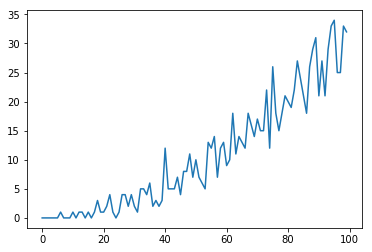

In [9]:
plt.plot(g)

In [13]:
g = periodic.get_mono_rdf(pos[:,:-1], 1000, 203.0)

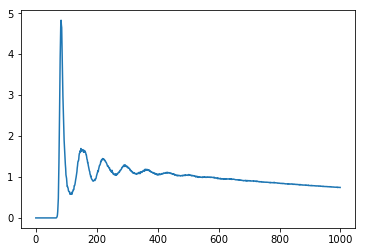

In [20]:
plt.plot(g.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))

In [70]:
%timeit periodic.get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 2.87 s per loop


In [34]:
def get_mono_rdf(pos, Nbins, L):
    maxdist = L/2.0
    g = np.zeros([len(pos), Nbins], int)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    for i in range(len(pos)):
        good = np.ones(len(pos), bool)
        good[i] = False
        dists = np.sqrt((periodic.periodify(pos[i], pos[good], L)**2).sum(-1))
        rs = (dists * l2r).astype(int)
        np.add.at(g[i], rs[rs<Nbins], 1)
    return g

In [56]:
g2 = get_mono_rdf(pos[:,:-1], 1000, 203.0)

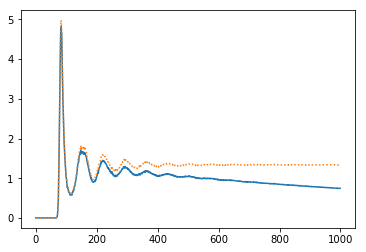

In [32]:
plt.plot(g.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [81]:
from numba import float64, int64
from math import sqrt, floor
@jit(int64[:,:](float64[:,:], int64, float64), nopython=True)
def numba_get_mono_rdf(pos, Nbins, L):
    maxdist = L/2.0
    rL = 1.0/L
    g = np.zeros((pos.shape[0], Nbins), np.int64)
    #conversion factor between indices and bins
    l2r = Nbins/maxdist
    for i in range(pos.shape[0]):
        for j in range(pos.shape[0]):
            if j==i:
                continue
            dist = 0
            for d in range(pos.shape[1]):
                diff = pos[i,d] - pos[j,d]
                diff -= L * floor(diff * rL + 0.5)
                dist += diff*diff
            dist = sqrt(dist)
            r = int(dist * l2r)
            if r<Nbins:
                g[i,r] += 1
    return g

In [82]:
g3 = numba_get_mono_rdf(pos[:,:-1], 1000, 203.0)

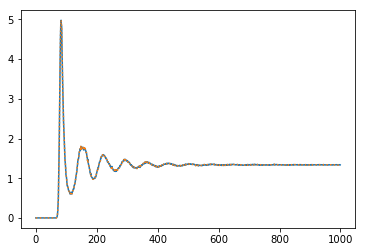

In [83]:
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g3.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [84]:
%timeit numba_get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 5.03 s per loop


In [4]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt, floor

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
@cython.cdivision(True) # turn off division by zero checking for entire function
def cython_get_mono_rdf(
    np.ndarray[np.float64_t, ndim=2] pos, 
    int Nbins, 
    float L
):
    cdef float maxdist = L/2.0
    cdef np.ndarray[np.int64_t, ndim=2] g = np.zeros((pos.shape[0], Nbins), np.int64)
    #conversion factor between indices and bins
    cdef float l2r = Nbins/maxdist
    cdef int i,j, r, d
    cdef float dist, diff
    for i in range(pos.shape[0]):
        for j in range(pos.shape[0]):
            if j==i:
                continue
            dist = 0
            for d in range(pos.shape[1]):
                diff = pos[i,d] - pos[j,d]
                diff -= L * floor(diff /L + 0.5)
                dist += diff*diff
            dist = sqrt(dist)
            r = int(dist * l2r)
            if r<Nbins:
                g[i,r] += 1
    return g

In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1809:0,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /data/mleocmach/.cache/ipython/cython/_cython_magic_eab24a72aafa0e638dac17a47d127bbe.c:258:
/home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^
In file included from /home/mathieu/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:27:0,
                 from /home/mathieu/anaconda3/env

In [65]:
g4 = cython_get_mono_rdf(pos[:,:-1], 1000, 203.0)

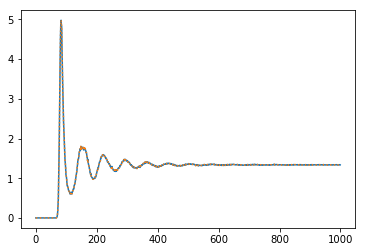

In [66]:
plt.plot(g2.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)))
plt.plot(g4.mean(0)*203**3/len(pos)/(4/3*np.pi*np.diff((np.arange(1001)/1001.*203./2)**3)), ls=':')

In [69]:
%timeit cython_get_mono_rdf(pos[:,:-1], 1000, 203.0)

1 loop, best of 3: 7.99 s per loop
